# Introduction

This notebook will illustrate experiments with the Adam optimizer in TensorFlow to solve the `diff1d_zero` PDE IVP. This is a sanity-check problem where a constant value of $0$ is the solution for all $(x,t)$.

## The `diff1d_zero` PDE problem

The differential equation is provided in the form:

\begin{equation}
    \frac {\partial \psi} {\partial t} = D \frac {\partial^2 \psi} {\partial x^2}
\end{equation}

or:

\begin{equation}
    G \left( x, t, \psi, \frac {\partial \psi} {dx}, \frac {\partial \psi} {\partial t}, \frac {\partial^2 \psi} {dx^2} \frac {\partial^2 \psi} {\partial t^2} \right) = \frac {\partial \psi} {\partial t} - D \frac {\partial^2 \psi} {\partial x^2} = 0
\end{equation}

with boundary conditions:

\begin{equation}
    f_0(0, t) = \psi(0, t) = 0 \\
    f_1(1, t) = \psi(1, t) = 0 \\
    g_0(x, 0) = \psi(x, 0) = 0
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x, t) = 0
\end{equation}

The analytical derivatives are:

\begin{equation}
    \frac {\partial \psi_a} {\partial x} = 0 \\
    \frac {\partial \psi_a} {\partial t} = 0 \\
    \frac {\partial^2 \psi_a} {\partial x^2} = 0 \\
    \frac {\partial^2 \psi_a} {\partial t^2} = 0
\end{equation}

The analytical solution in the domain $0 \leq x,t \leq 1$ is plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
from math import exp
import os
import platform
import sys

# Import 3rd-party modules.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Import TensorFlow.
import tensorflow as tf

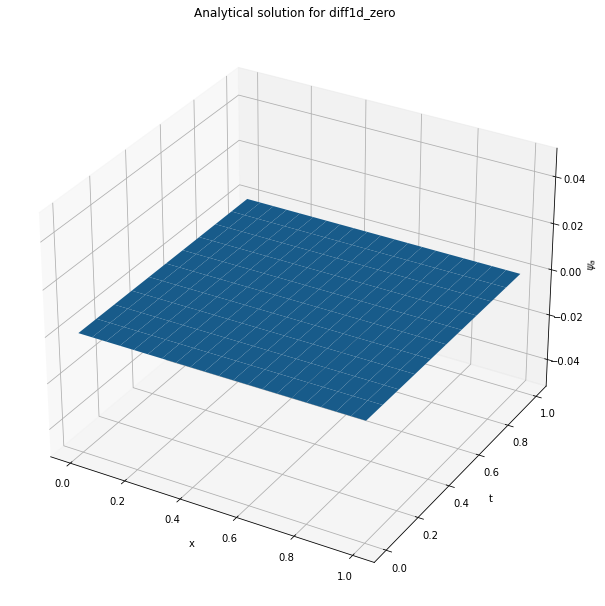

In [2]:
# Import the problem definition.
eq_name = "diff1d_zero"
eq_module = 'nnde.differentialequation.examples.diff1d_zero'
eq = importlib.import_module(eq_module)

# Compute the analytical solution and derivatives.
# Note that Y is used in place of \psi in the code.
nx_analytic = 21
nt_analytic = 11
x_analytic = np.linspace(0, 1, nx_analytic)
t_analytic = np.linspace(0, 1, nt_analytic)
Ya_analytic = [[eq.Ya([x, t]) for x in x_analytic] for t in t_analytic]
Ya_analytic = np.array(Ya_analytic)
# Rows are in order of increasing t.
# Columns are in order of increasing x.

# Plot the analytical solution.
fig = plt.figure(figsize=(8, 8))
(X, Y) = np.meshgrid(x_analytic, t_analytic)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Ya_analytic)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$\psi_a$')
ax.set_title('Analytical solution for %s' % eq_name)
plt.show()

## Solving `diff1d_zero` using TensorFlow

In [3]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [4]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [5]:
from nnde.math.trainingdata import create_training_grid2

def create_training_data(*n_train):
    x_train = np.array(create_training_grid2(*n_train))
    return x_train

In [6]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [7]:
print_system_information()

System report:
2021-09-25 17:45:20.840651
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Mon Aug 30 06:12:21 PDT 2021; root:xnu-7195.141.6~3/RELEASE_X86_64', machine='x86_64')
Python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
Python build: ('default', 'Sep 16 2021 08:50:36')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [8]:
# Set the run parameters and create the training data.

# Output directory.
path = "./diff1d_zero_tf_adam"
output_dir = create_output_directory(path)

# Training optimizer.
training_algorithm = "Adam"

# Initial parameter ranges.
w0_range = [-0.1, 0.1]
u0_range = [-0.1, 0.1]
v0_range = [-0.1, 0.1]

# Number of hidden nodes.
H = 10

# Number of training points in each dimension, and total.
nx_train = 11
nt_train = 21
n_train = nx_train*nt_train

# Number of training epochs.
n_epochs = 1000

# Learning rate.
learning_rate = 0.01

# Random number generator seed.
random_seed = 0

# Create and save the training data.
# This is a list of nx*nt elements, where each element is a (x,t) pair.
# The t column varies fastest, i.e. the order is like:
# (x[0],t[0]), (x[0],t[1]), ..., (x[0],t[nt-1]), (x[1],t[0]), (x[1], t[1]), ...
xt_train = create_training_data(nx_train, nt_train)
np.savetxt(os.path.join(output_dir,'xt_train.dat'), xt_train)

# Extract unique values of the training coordinates for convenience.
x_train = xt_train[::nt_train, 0]
t_train = xt_train[:nt_train, 1]

In [9]:
# Build the model, but do not initialize parameters yet.
model = build_model(H, w0_range, u0_range, v0_range)

# Create the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

2021-09-25 17:45:21.380358: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Train the model.

# Convert the training data to a TensorFlow variable, so it can be used for
# gradient computation.
xt_train_v = tf.Variable(xt_train, dtype=tf.float32)

# Rename the training data Variable for convenience, just for training.
xt = xt_train_v
x = xt[:, 0]
t = xt[:, 1]

# Create history variables for losses and model parameters.
L_hist = []
p_hist = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

print("Hyperparameters: n_train = %s, H = %s, n_epochs = %s, learning_rate = %s"
      % (n_train, H, n_epochs, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(n_epochs):
#     print("Starting epoch %s." % epoch)

    # Run the forward pass.
    with tf.GradientTape(persistent=True) as tape3:
        with tf.GradientTape(persistent=True) as tape2:
            with tf.GradientTape(persistent=True) as tape1:

                # Compute the network output.
                N = model(xt)

                # Compute the boundary condition function.
                A = eq.C

                # Compute the trial solution.
                Y = A + x*(1 - x)*t*N[:, 0]

            # Compute the gradient of trial solution wrt inputs.
            dY_dx = tape1.gradient(Y, xt)

        # Compute the Laplacian of trial solution wrt inputs.
        d2Y_dx2 = tape2.gradient(dY_dx, xt)

        # Compute the estimates of the differential equation.
        G = dY_dx[:, 1] - eq.D * d2Y_dx2[:, 0]

        # Compute the loss function.
        L = tf.math.sqrt(tf.reduce_sum(G**2)/n_train)

        # Save the current losses.
        L_hist.append(L.numpy())

    # Save the parameters used in this pass.
    p_hist.append(
        np.hstack(
            (model.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
             model.trainable_variables[1].numpy(),       # u (H,) row vector
             model.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Compute the gradient of the loss function wrt the network parameters.
    p_grad = tape3.gradient(L, model.trainable_variables)

    # Update the parameters for this pass.
    optimizer.apply_gradients(zip(p_grad, model.trainable_variables))

#     print("Ending epoch %s." % epoch)

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())

Hyperparameters: n_train = 231, H = 10, n_epochs = 1000, learning_rate = 0.01
Training started at 2021-09-25 17:45:21.398083
Training stopped at 2021-09-25 17:45:26.440911
Total training time was 5.042828 seconds.


In [11]:
# Save the loss history.
np.savetxt(os.path.join(output_dir, 'L_hist.dat'), np.array(L_hist))

# Save the parameter histories.
# One line per epoch, with w[] split between wx and wt.
# Each line is in the format:
# w[0:H],w[H:2*H],u[:],v[:]
# i.e.
# wx[:],wt[:],u[:],v[:]
np.savetxt(os.path.join(output_dir, 'p_hist.dat'), np.array(p_hist))

In [12]:
# Compute and save the trained solution (Yt) and derivatives at training points (_train).
# Training data renamed again for convenience.
xt = xt_train_v
x = xt[:, 0]
t = xt[:, 1]
with tf.GradientTape(persistent=True) as tape2:
    with tf.GradientTape(persistent=True) as tape1:
        N = model(xt)
        A = eq.C
        Yt_train = A + x*(1 - x)*t*N[:, 0]
    dYt_dx_train = tape1.gradient(Yt_train, xt)
d2Yt_dx2_train = tape2.gradient(dYt_dx_train, xt)
np.savetxt(os.path.join(output_dir, 'Yt_train.dat'), Yt_train.numpy())
np.savetxt(os.path.join(output_dir, 'dYt_dx_train.dat'), dYt_dx_train[:, 0].numpy())
np.savetxt(os.path.join(output_dir, 'dYt_dt_train.dat'), dYt_dx_train[:, 1].numpy())
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_train.dat'), d2Yt_dx2_train[:, 0].numpy())
np.savetxt(os.path.join(output_dir, 'd2Yt_dt2_train.dat'), d2Yt_dx2_train[:, 1].numpy())

In [13]:
# Compute and save the analytical solution (Ya) and derivatives at training points (_train).
Ya_train = np.array([eq.Ya(xt) for xt in xt_train])
dYa_dx_train = np.array([eq.dYa_dx(xt) for xt in xt_train])
dYa_dt_train = np.array([eq.dYa_dt(xt) for xt in xt_train])
d2Ya_dx2_train = np.array([eq.d2Ya_dx2(xt) for xt in xt_train])
d2Ya_dt2_train = np.array([eq.d2Ya_dt2(xt) for xt in xt_train])
np.savetxt(os.path.join(output_dir,'Ya_train.dat'), Ya_train)
np.savetxt(os.path.join(output_dir,'dYa_dx_train.dat'), dYa_dx_train)
np.savetxt(os.path.join(output_dir,'dYa_dt_train.dat'), dYa_dt_train)
np.savetxt(os.path.join(output_dir,'d2Ya_dx2_train.dat'), d2Ya_dx2_train)
np.savetxt(os.path.join(output_dir,'d2Ya_dt2_train.dat'), d2Ya_dt2_train)

In [14]:
# Compute and save the error (_err) in the trained solution (Yt) and derivatives at training points (_train).
Yt_err_train = Yt_train.numpy() - Ya_train
dYt_dx_err_train = dYt_dx_train[:, 0].numpy() - dYa_dx_train
dYt_dt_err_train = dYt_dx_train[:, 1].numpy() - dYa_dt_train
d2Yt_dx2_err_train = d2Yt_dx2_train[:, 0].numpy() - d2Ya_dx2_train
d2Yt_dt2_err_train = d2Yt_dx2_train[:, 1].numpy() - d2Ya_dt2_train
np.savetxt(os.path.join(output_dir, 'Yt_err_train.dat'), Yt_err_train)
np.savetxt(os.path.join(output_dir, 'dYt_dx_err_train.dat'), dYt_dx_err_train)
np.savetxt(os.path.join(output_dir, 'dYt_dt_err_train.dat'), dYt_dt_err_train)
np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_err_train.dat'), d2Yt_dx2_err_train)
np.savetxt(os.path.join(output_dir, 'd2Yt_dt2_err_train.dat'), d2Yt_dt2_err_train)

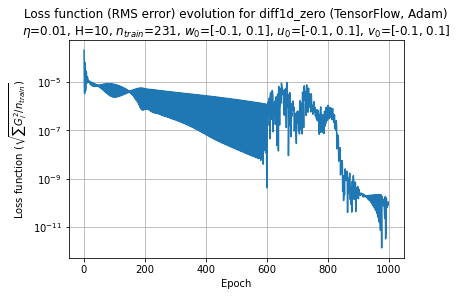

In [15]:
# Plot the loss function history.
plt.semilogy(L_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/n_{train}}$)")
plt.grid()
plt.title("Loss function (RMS error) evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.show()

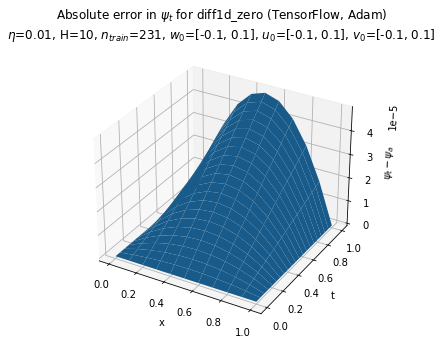

In [16]:
# Plot the error in the trained solution at the training points.
fig = plt.figure()
(X, T) = np.meshgrid(x_train, t_train)
# Each row of Z is the x-profile at a single t value.
# Transpose is needed to get to correct order for (X,T).
Z = Yt_err_train.reshape((nx_train, nt_train)).T
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, T, Z)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$\psi_t-\psi_a$')
ax.set_title("Absolute error in $\psi_t$ for %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.show()

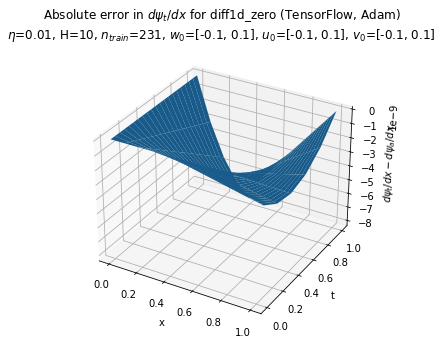

In [17]:
# Plot the error (_err) in the trained dY/dx (dYt_dx) at the training points (_train).
fig = plt.figure()
(X, T) = np.meshgrid(x_train, t_train)
# Each row of Z is the x-profile at a single t value.
# Transpose is needed to get to correct order for (X,T).
Z = dYt_dx_err_train.reshape((nx_train, nt_train)).T
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, T, Z)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$d\psi_t/dx-d\psi_a/dx$')
ax.set_title("Absolute error in $d\psi_t/dx$ for %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.show()

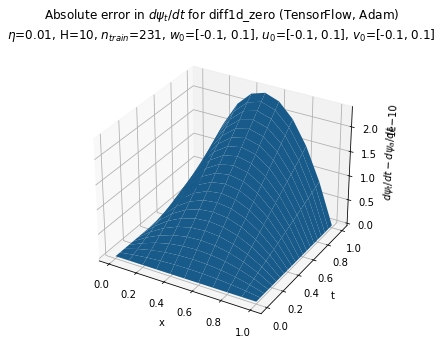

In [18]:
# Plot the error (_err) in the trained dY/dt (dYt_dt) at the training points (_train).
fig = plt.figure()
(X, T) = np.meshgrid(x_train, t_train)
# Each row of Z is the x-profile at a single t value.
# Transpose is needed to get to correct order for (X,T).
Z = dYt_dt_err_train.reshape((nx_train, nt_train)).T
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, T, Z)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$d\psi_t/dt-d\psi_a/dt$')
ax.set_title("Absolute error in $d\psi_t/dt$ for %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.show()

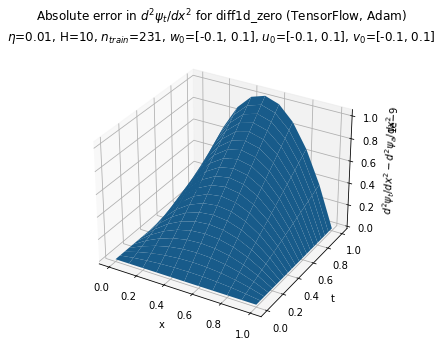

In [19]:
# Plot the error (_err) in the trained d2Y/dx2 (d2Yt_dx2) at the training points (_train).
fig = plt.figure()
(X, T) = np.meshgrid(x_train, t_train)
# Each row of Z is the x-profile at a single t value.
# Transpose is needed to get to correct order for (X,T).
Z = d2Yt_dx2_err_train.reshape((nx_train, nt_train)).T
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, T, Z)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$d^2\psi_t/dx^2-d^2\psi_a/dx^2$')
ax.set_title("Absolute error in $d^2\psi_t/dx^2$ for %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.show()

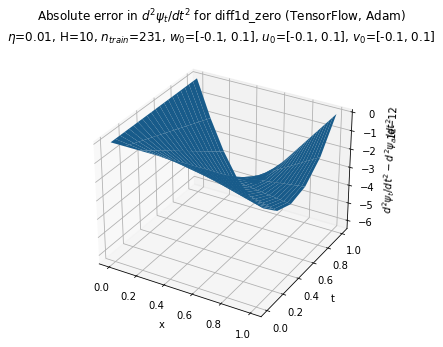

In [20]:
# Plot the error (_err) in the trained d2Y/dt2 (d2Yt_dt2) at the training points (_train).
fig = plt.figure()
(X, T) = np.meshgrid(x_train, t_train)
# Each row of Z is the x-profile at a single t value.
# Transpose is needed to get to correct order for (X,T).
Z = d2Yt_dt2_err_train.reshape((nx_train, nt_train)).T
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, T, Z)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$d^2\psi_t/dt^2-d^2\psi_a/dt^2$')
ax.set_title("Absolute error in $d^2\psi_t/dt^2$ for %s (%s, %s)\n$\eta$=%s, H=%s, $n_{train}$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.show()

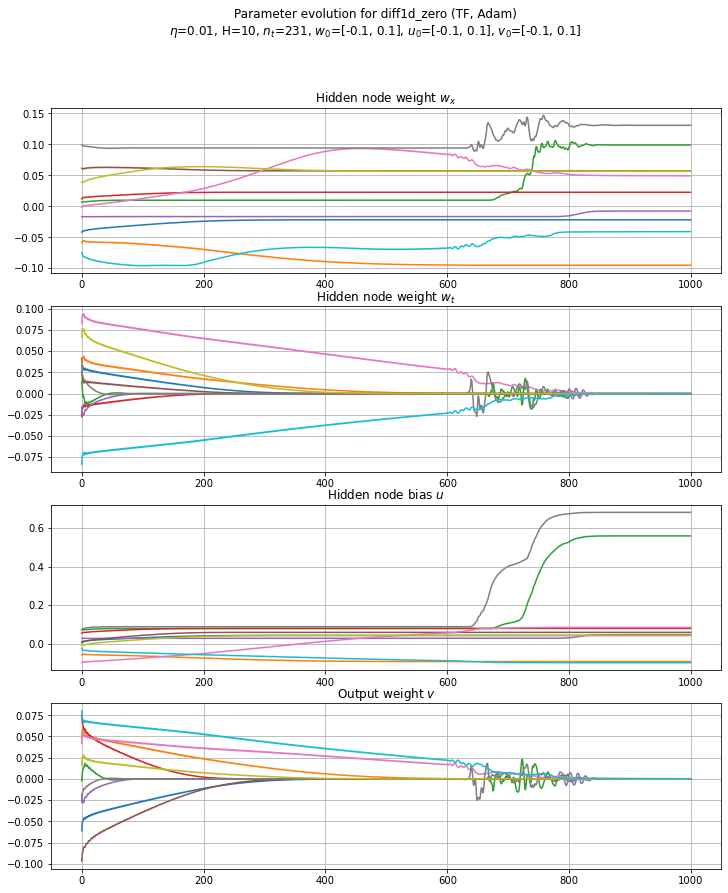

In [21]:
# Plot the parameter histories.
p_hist = np.array(p_hist)
plt.figure(figsize=(12, 14))

# w_x
plt.subplot(411)
plt.plot(p_hist[:, 0:H])
plt.title("Hidden node weight $w_x$")
plt.grid()

# w_t
plt.subplot(412)
plt.plot(p_hist[:, H:2*H])
plt.title("Hidden node weight $w_t$")
plt.grid()

# u
plt.subplot(413)
plt.plot(p_hist[:, 2*H:3*H])
plt.title("Hidden node bias $u$")
plt.grid()

# v
plt.subplot(414)
plt.plot(p_hist[:, 3*H:4*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TF', training_algorithm, learning_rate, H, n_train, w0_range, u0_range, v0_range))
plt.subplots_adjust(hspace=0.2)
plt.show()